# 1.5 「ファインチューニング」で精度向上を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、ファインチューニングでアリとハチの画像を分類するモデルを学習します



# 学習目標

1.	PyTorchでGPUを使用する実装コードを書けるようになる
2.	最適化手法の設定において、層ごとに異なる学習率を設定したファインチューニングを実装できるようになる
3.	学習したネットワークを保存・ロードできるようになる



# 事前準備

- 1.4節で解説したAWS EC2 のGPUインスタンスを使用します


In [1]:
# パッケージのimport
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [2]:
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 False


In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [5]:
OUTPUT_FEATURES = 2

LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.5

NUM_EPOCHS = 8

# DatasetとDataLoaderを作成

In [6]:
# 1.3節で作成したクラスを同じフォルダにあるmake_dataset_dataloader.pyに記載して使用
from utils.dataloader_image_classification import (
    HymenopteraDataset,
    ImageTransform,
    make_datapath_list,
)

# アリとハチの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Datasetを作成する
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
)


# DataLoaderを作成する
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


# モデルを学習させる関数を作成

In [7]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    history = {}
    history["train"] = {}
    history["val"] = {}
    history["train"]["loss"] = []
    history["train"]["acc"] = []
    history["val"]["loss"] = []
    history["val"]["acc"] = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        # print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == "train"):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)
    return history

# 損失関数を定義

In [8]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークモデルの作成

In [9]:
vgg_models = {
    "vgg16": (models.vgg16, models.VGG16_Weights.DEFAULT),
    "vgg16_bn": (models.vgg16_bn, models.VGG16_BN_Weights.DEFAULT),
    "vgg19": (models.vgg19, models.VGG19_Weights.DEFAULT),
    "vgg19_bn": (models.vgg19_bn, models.VGG19_BN_Weights.DEFAULT),
}

In [10]:
vgg_results = {}
for name, (model, weights) in vgg_models.items():
    _net = model(weights=weights)
    num_classifier_layers = len(_net.classifier)
    last_in_features = _net.classifier[num_classifier_layers - 1].in_features
    _net.classifier[num_classifier_layers - 1] = nn.Linear(
        in_features=last_in_features, out_features=OUTPUT_FEATURES
    )
    _net.train()
    print("Model:", name, num_classifier_layers, last_in_features)

    # # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
    # for param in _net.parameters():
    #     param.requires_grad = False

    params_to_update = []
    for param in _net.classifier[num_classifier_layers - 1].parameters():
        param.requires_grad = True
        params_to_update.append(param)

    # optimizer = optim.SGD(
    #     params_to_update,
    #     lr=LEARNING_RATE,
    #     momentum=MOMENTUM,
    # )
    optimizer = optim.Adam(
        params_to_update,
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )

    history = train_model(
        _net, dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS
    )
    vgg_results[name] = history

Model: vgg16 7 4096
使用デバイス： cpu
Epoch 1/8


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


val Loss: 0.7702 Acc: 0.4444
Epoch 2/8


100%|██████████| 8/8 [00:41<00:00,  5.18s/it]


train Loss: 0.3731 Acc: 0.8189


100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


val Loss: 0.1313 Acc: 0.9608
Epoch 3/8


100%|██████████| 8/8 [00:41<00:00,  5.18s/it]


train Loss: 0.1208 Acc: 0.9630


100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


val Loss: 0.1145 Acc: 0.9477
Epoch 4/8


100%|██████████| 8/8 [00:42<00:00,  5.25s/it]


train Loss: 0.0651 Acc: 0.9753


100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


val Loss: 0.1040 Acc: 0.9477
Epoch 5/8


100%|██████████| 8/8 [00:41<00:00,  5.22s/it]


train Loss: 0.0762 Acc: 0.9712


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


val Loss: 0.0970 Acc: 0.9477
Epoch 6/8


100%|██████████| 8/8 [00:43<00:00,  5.40s/it]


train Loss: 0.0600 Acc: 0.9794


100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


val Loss: 0.0909 Acc: 0.9477
Epoch 7/8


100%|██████████| 8/8 [00:42<00:00,  5.29s/it]


train Loss: 0.0477 Acc: 0.9794


100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


val Loss: 0.0960 Acc: 0.9542
Epoch 8/8


100%|██████████| 8/8 [00:42<00:00,  5.28s/it]


train Loss: 0.0412 Acc: 0.9918


100%|██████████| 5/5 [00:26<00:00,  5.31s/it]


val Loss: 0.0945 Acc: 0.9542
Model: vgg16_bn 7 4096
使用デバイス： cpu
Epoch 1/8


 80%|████████  | 4/5 [00:25<00:06,  6.45s/it]

KeyboardInterrupt



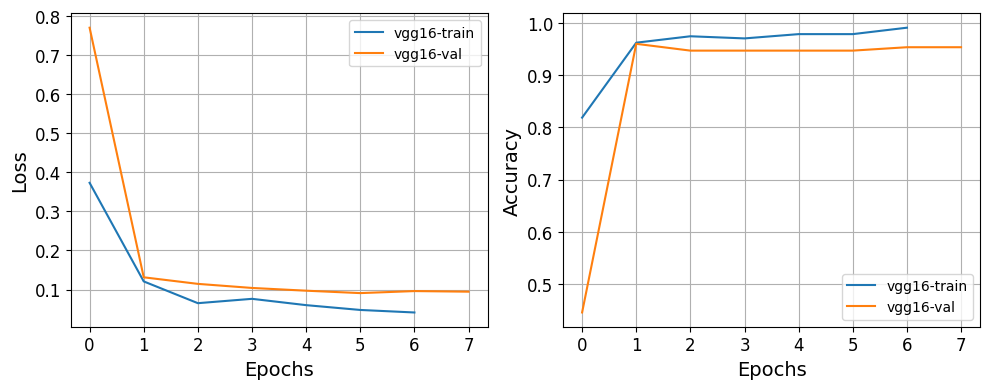

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for model in vgg_results.keys():
    for phase in vgg_results[model].keys():
        axes[0].plot(
            range(len(vgg_results[model][phase]["loss"])),
            vgg_results[model][phase]["loss"],
            label=f"{model}-{phase}",
        )
axes[0].set_xlabel("Epochs", size=14)
axes[0].set_ylabel("Loss", size=14)
axes[0].tick_params(labelsize=12)
axes[0].grid()
axes[0].legend()

for model in vgg_results.keys():
    for phase in vgg_results[model].keys():
        axes[1].plot(
            range(len(vgg_results[model][phase]["acc"])),
            vgg_results[model][phase]["acc"],
            label=f"{model}-{phase}",
        )
axes[1].set_xlabel("Epochs", size=14)
axes[1].set_ylabel("Accuracy", size=14)
axes[1].tick_params(labelsize=12)
axes[1].grid()
axes[1].legend()
plt.show()

# 学習したネットワークを保存・ロード

In [ ]:
# # PyTorchのネットワークパラメータの保存
# save_path = "./weights_fine_tuning.pth"
# torch.save(net.state_dict(), save_path)

In [ ]:
# # PyTorchのネットワークパラメータのロード
# load_path = "./weights_fine_tuning.pth"
# load_weights = torch.load(load_path)
# net.load_state_dict(load_weights)

# # GPU上で保存された重みをCPU上でロードする場合
# load_weights = torch.load(load_path, map_location={"cuda:0": "cpu"})
# net.load_state_dict(load_weights)

以上